In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#Progress bar
from tqdm import tqdm

#Image pre-processing
from PIL import Image

#For reading CSV and for math
import numpy as np
import pandas as pd

#Visualize some datasets
import matplotlib.pyplot as plt

#Check our work directory
import os
import shutil

# Constants

In [11]:
LR = 0.001
BATCH_SIZE = 4
EPOCHS = 15

# Data section

In [12]:
blur_path = r'dataset\blur'
sharp_path = r'dataset\not_blur'

In [23]:
#Analyzing resolutions of dataset

resolutions_blur = []
for filename in tqdm(os.listdir(blur_path)):
    file_path = os.path.join(blur_path, filename)
    im = Image.open(file_path)
    width, size = im.size
    resolutions_blur.append((width, size))

resolutions_sharp = []
for filename in tqdm(os.listdir(sharp_path)):
    file_path = os.path.join(sharp_path, filename)
    im = Image.open(file_path)
    width, size = im.size
    resolutions_sharp.append((width, size))

resolutions_blur.sort()
resolutions_sharp.sort()
#print(resolutions)

100%|██████████| 16535/16535 [01:00<00:00, 272.55it/s]


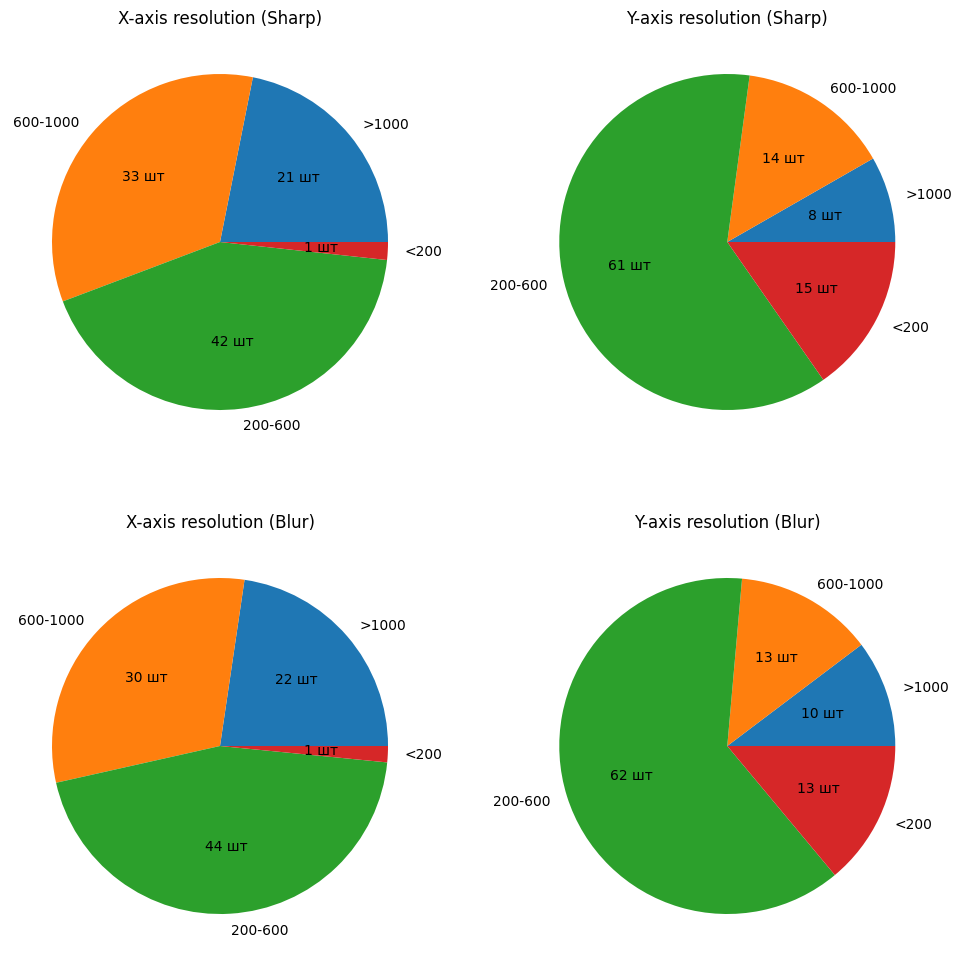

In [42]:
def get_values(list):
    values_0, values_1 = [0] * 4, [0] * 4
    for i in list:
        if i[0] > 1000:
            values_0[0] += 1
        elif i[0] <= 1000 and i[0] > 600:
            values_0[1] += 1
        elif i[0] <= 600 and i[0] > 200:
            values_0[2] += 1
        elif i[0] <= 200:
            values_0[3] += 1
        
        if i[1] > 1000:
            values_1[0] += 1
        elif i[1] <= 1000 and i[1] > 600:
            values_1[1] += 1
        elif i[1] <= 600 and i[1] > 200:
            values_1[2] += 1
        elif i[1] <= 200:
            values_1[3] += 1

    return values_0, values_1


categories = ['>1000', '600-1000', '200-600', '<200']

values_X_sharp, values_Y_sharp = get_values(resolutions_sharp)
values_X_blur, values_Y_blur = get_values(resolutions_blur)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

ax1.pie(values_X_sharp, labels=categories, autopct='%d шт')
ax1.set_title('X-axis resolution (Sharp)')

ax2.pie(values_Y_sharp, labels=categories, autopct='%d шт')
ax2.set_title('Y-axis resolution (Sharp)')

ax3.pie(values_X_blur, labels=categories, autopct='%d шт')
ax3.set_title('X-axis resolution (Blur)')

ax4.pie(values_Y_blur, labels=categories, autopct='%d шт')
ax4.set_title('Y-axis resolution (Blur)')


plt.show()

# Model section

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # input [3, 640, 640]
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),  # [64, 640, 640]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),      # [64, 320, 320]

            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1), # [128, 320, 320]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),      # [128, 160, 160]

            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1), # [256, 160, 160]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),      # [256, 80, 80]

            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1), # [512, 80, 80]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),       # [512, 40, 40]
            
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1), # [512, 40, 40]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),       # [512, 20, 20]
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features = 512*20*20, out_features = 1024),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = 512),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = 128), 
            nn.ReLU(), 
            nn.Linear(in_features = 128, out_features = 2)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)
net = Net()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print('Using: ',device)
net.to(device)

# Training and validation section